In [1]:
import tensorflow as tf
import tensorflow.keras
import  tensorflow.keras.layers as L, tensorflow.keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import keras_utils
import numpy as np
import cv2
import random
# from tensorflow.keras_tqdm import TQDMNotebookCallback
import sys
import os
import os.path
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
sys.path.append("..")

In [2]:
#loading the dataset
all_paths =[]
for dirpath, dirnames, filenames in os.walk(r"C:\Users\Varun\Desktop\IIT-A\Sub_Dataset\alined_mor_eve\evealignedmor"):
    for filename in [f for f in filenames if f.endswith(".png")]:
        all_paths.append(os.path.join(dirpath, filename))

In [3]:
# all_paths

In [4]:
random.shuffle(all_paths)

In [5]:
x = []
counter = 0
for i in all_paths:
    img = cv2.imread(i)
    img = cv2.resize(img,(512,512))
    img = img/255
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x.append(img)
    counter += 1
x = np.array(x)


In [6]:
x_train = x[0:int(984*0.7)]
x_test = x[int(984*0.7):]
print(x_train.shape, x_test.shape, x_train.shape[0]+x_test.shape[0])

(688, 512, 512, 3) (296, 512, 512, 3) 984


In [7]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
#     visible = Input(shape=img_shape)
#     conv1 = Conv2D(32, kernel_size=3,padding = 'same', activation='relu')(visible)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(64, kernel_size=3,padding = 'same', activation='relu')(pool1)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(128, kernel_size=3,padding = 'same', activation='relu')(pool2)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = Conv2D(256, kernel_size=3,padding = 'same', activation='relu')(pool3)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
#     flat = Flatten()(pool4)
#     dense =Dense(code_size)(flat)
#     encoder = Model(inputs=visible, outputs=dense)
    encoder = tensorflow.keras.models.load_model(r"encoder_morning_train")
    for layers in encoder.layers[-3:]:
        layers.trainable = False
   

    # decoder
#     visible_d = Input(shape=code_size)
#     dense_d = Dense(32*32*256)(visible_d)
#     reshape_d = Reshape((32,32,256))(dense_d)
#     conv1_d = Conv2DTranspose(128, kernel_size=3,strides = 2, padding = 'same', activation='relu')(reshape_d)
#     conv2_d = Conv2DTranspose(64, kernel_size=3,strides = 2, padding = 'same', activation='relu')(conv1_d)
#     conv3_d = Conv2DTranspose(32, kernel_size=3,strides = 2, padding = 'same', activation='relu')(conv2_d)
#     conv4_d = Conv2DTranspose(3, kernel_size=3,strides = 2, padding = 'same', activation=None)(conv3_d)
    
#     decoder = Model(inputs= visible_d, outputs = conv4_d )
    decoder = tensorflow.keras.models.load_model("decoder_morning_train")
    
    
    return encoder, decoder

In [8]:
IMG_SHAPE = (512,512,3)
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
encoder.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 512, 512, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 256)     

In [9]:
decoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 262144)            134479872 
_________________________________________________________________
reshape_7 (Reshape)          (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 64, 64, 128)       295040    
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 128, 128, 64)      73792     
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 256, 256, 32)      18464     
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 512, 512, 3)       867       
Total params: 134,868,035
Trainable params: 134,868,035
Non-trainable params: 0
_______________________________________

In [10]:
IMG_SHAPE = (512,512,3)
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [512]:
#     s = reset_tf_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")
# s = reset_tf_session()

Testing code size 512
All tests passed!


In [11]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tensorflow.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse',metrics=['accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential_15 (Sequential)   (None, 512)               134606656 
_________________________________________________________________
sequential_16 (Sequential)   (None, 512, 512, 3)       134868035 
Total params: 269,474,691
Trainable params: 135,256,451
Non-trainable params: 134,218,240
_________________________________________________________________


In [12]:
# we will save model checkpoints here to continue training in case of kernel death
# model_filename = 'autoencoder.{0:03d}.hdf5'
# last_finished_epoch = 0
# fill `last_finished_epoch` with your latest finished epoch
# from tensorflow.keras.models import load_model
# model_filename = r'C:\Users\Varun\Desktop\IIT-A\Notebooks\auto_encoder_evening_train.050.hdf5'
# # s = reset_tf_session()
# last_finished_epoch = 40
# autoencoder = load_model(model_filename)
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [13]:
# autoencoder_history = autoencoder.fit(x=x_train, y=x_train, epochs=40,batch_size =16,
#                 validation_data=(x_test, x_test),
#                 verbose=1, initial_epoch=last_finished_epoch or 0)

In [14]:
# autoencoder.save("auto_encoder_morning_on_evening_aligned.040.hdf5")

In [15]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

In [16]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

In [17]:
from tensorflow.keras.models import load_model
model_filename = r'C:\Users\Varun\Desktop\IIT-A\Notebooks\auto_encoder_morning_on_evening_aligned.040.hdf5'
last_finished_epoch = 40
autoencoder = load_model(model_filename.format(last_finished_epoch))
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

10/10 [==============================] - 30s 3s/step - loss: 0.0106 - accuracy: 0.4507
Convolutional autoencoder MSE: [0.010587879456579685, 0.45067358016967773]


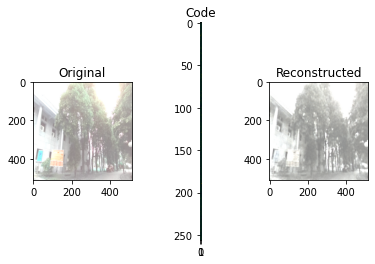

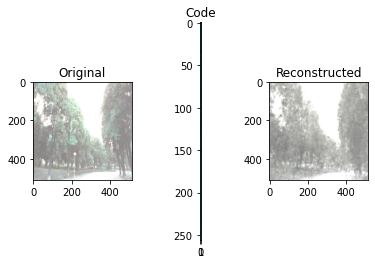

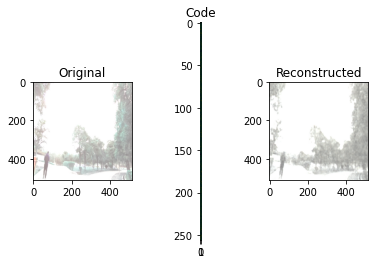

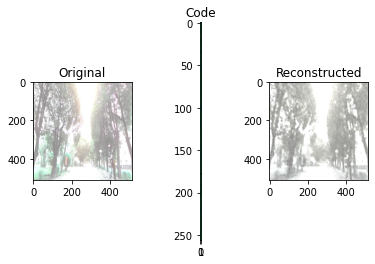

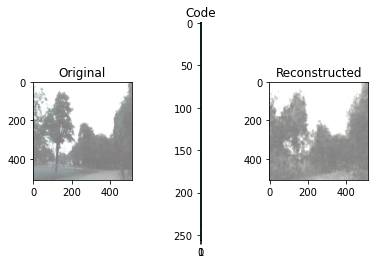

In [18]:
reconstruction_mse = autoencoder.evaluate(x_test, x_test, verbose=1)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder)

In [19]:
from tqdm.notebook import tqdm

# Morning_Predictions

In [20]:
from tensorflow.keras.models import load_model
model_filename = r'C:\Users\Varun\Desktop\IIT-A\Notebooks\auto_encoder_morning_on_evening_aligned.040.hdf5'
last_finished_epoch = 40
autoencoder = load_model(model_filename.format(last_finished_epoch))
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [21]:
dictionary = {}
for i in range(984):
#     print(i)
    dictionary[i] = r'C:\Users\Varun\Desktop\IIT-A\Sub_Dataset\alined_mor_eve\evealignedmor/' + '%d.png'%i
    

In [22]:
dictionary

{0: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/0.png',
 1: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/1.png',
 2: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/2.png',
 3: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/3.png',
 4: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/4.png',
 5: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/5.png',
 6: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/6.png',
 7: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/7.png',
 8: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/8.png',
 9: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/9.png',
 10: 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\evealignedmor/10.png',
 11: 'C:

In [23]:
# all_paths_morning =[]
# for dirpath, dirnames, filenames in os.walk(r"C:\Users\Varun\Desktop\IIT-A\Sub_Dataset\Morning_Equivalent_Train"):
#     for filename in [f for f in filenames if f.endswith(".jpg")]:
#         all_paths_morning.append(os.path.join(dirpath, filename))
        
# all_paths_morning

In [24]:
x_morning = []
counter = 0
for i in tqdm(range(984)):
    img = cv2.imread(dictionary[i])
    img = cv2.resize(img,(512,512))
    img = img/255
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_morning.append(img)
    counter += 1
x_morning = np.array(x_morning)
print(x_morning[0].shape)

  0%|          | 0/984 [00:00<?, ?it/s]

(512, 512, 3)


In [25]:
feature_maps_morning = []
for i in tqdm(x_morning):
    code = encoder.predict(i[None])[0]
    feature_maps_morning.append(code)

  0%|          | 0/984 [00:00<?, ?it/s]

In [26]:
# np.save("Feature_Maps_Auto_Encoder_Morning",feature_maps_morning)

# Evening_Predictions

In [27]:
all_paths_evening =[]
for dirpath, dirnames, filenames in os.walk(r"C:\Users\Varun\Desktop\IIT-A\Sub_Dataset\alined_mor_eve\eve"):
    for filename in [f for f in filenames if f.endswith(".png")]:
        all_paths_evening.append(os.path.join(dirpath, filename))
all_paths_evening

['C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\000000.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\000001.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\0000010.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\00000100.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\00000101.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\00000102.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\00000103.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\00000104.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\00000105.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\00000106.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\00000107.png',
 'C:\\Users\\Varun\\Desktop\\IIT-A\\Sub_Dataset\\alined_mor_eve\\eve\\

In [28]:
x_evening = []
counter = 0
for i in tqdm(all_paths_evening):
    img = cv2.imread(i)
    img = cv2.resize(img,(512,512))
    img = img/255
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_evening.append(img)
    counter += 1
x_evening = np.array(x_evening)
print(x_evening)

  0%|          | 0/984 [00:00<?, ?it/s]

[[[[0.98039216 1.         0.98039216]
   [0.98039216 1.         0.98431373]
   [0.97647059 1.         0.97647059]
   ...
   [0.39215686 0.36862745 0.32941176]
   [0.40392157 0.4        0.32941176]
   [0.32156863 0.31372549 0.24313725]]

  [[0.98039216 1.         0.97647059]
   [0.97647059 1.         0.98823529]
   [0.97647059 1.         0.97647059]
   ...
   [0.45490196 0.43921569 0.37647059]
   [0.42352941 0.42352941 0.34509804]
   [0.30196078 0.29019608 0.21176471]]

  [[0.98431373 1.         0.96078431]
   [0.97647059 1.         0.98039216]
   [0.98431373 1.         0.97254902]
   ...
   [0.4627451  0.45882353 0.39607843]
   [0.38431373 0.39607843 0.30980392]
   [0.29019608 0.28627451 0.20784314]]

  ...

  [[0.65098039 0.67843137 0.64313725]
   [0.65490196 0.67843137 0.65098039]
   [0.6627451  0.68627451 0.64313725]
   ...
   [0.46666667 0.61176471 0.55294118]
   [0.47843137 0.61568627 0.56078431]
   [0.49411765 0.64705882 0.57647059]]

  [[0.66666667 0.69019608 0.64313725]
   [0.6

In [29]:
feature_maps_evening = []
for i in tqdm(x_evening):
    code = encoder.predict(i[None])[0]
    feature_maps_evening.append(code)

  0%|          | 0/984 [00:00<?, ?it/s]

In [ ]:
# np.save("Feature_Maps_auto_encoder_evening",feature_maps_evening)

# Distance_matrix

In [40]:
from math import sqrt
from tqdm.notebook import tqdm
 
# calculate euclidean distance
def euclidean_distance(a, b):
	return sqrt(sum((e1-e2)**2 for e1, e2 in zip(a,b)))

distance_table = np.empty((984, 984), float)
for i in tqdm(range(len(feature_maps_morning))):
    for j in range(len(feature_maps_evening)):
        c = feature_maps_evening[i].flatten()
        d = feature_maps_morning[j].flatten() 
        
        distance = euclidean_distance(c,d)
#         print(np.array(distance))
        distance_table[i][j] = distance
# print(distance_table[0][0])

  0%|          | 0/984 [00:00<?, ?it/s]

In [41]:
print(distance_table)

[[101.5636189   93.66756987  93.66756987 ... 109.86984217 109.86984217
  109.86984217]
 [129.16146723 128.75307551 128.75307551 ... 128.02750631 128.02750631
  128.02750631]
 [124.3129926  128.28555717 128.28555717 ... 122.7115469  122.7115469
  122.7115469 ]
 ...
 [116.78755261 108.50575883 108.50575883 ... 103.38374964 103.38374964
  103.38374964]
 [115.41000188 107.48234176 107.48234176 ... 104.14966983 104.14966983
  104.14966983]
 [ 97.00950481 101.28298182 101.28298182 ... 105.22799466 105.22799466
  105.22799466]]


# Distance To Probablity 

In [42]:
one = np.ones(distance_table.shape)
one.shape

(984, 984)

In [43]:
out = np.divide(one,distance_table)
out

array([[0.00984605, 0.01067605, 0.01067605, ..., 0.00910168, 0.00910168,
        0.00910168],
       [0.00774225, 0.0077668 , 0.0077668 , ..., 0.00781082, 0.00781082,
        0.00781082],
       [0.00804421, 0.00779511, 0.00779511, ..., 0.00814919, 0.00814919,
        0.00814919],
       ...,
       [0.00856256, 0.0092161 , 0.0092161 , ..., 0.0096727 , 0.0096727 ,
        0.0096727 ],
       [0.00866476, 0.00930385, 0.00930385, ..., 0.00960157, 0.00960157,
        0.00960157],
       [0.01030827, 0.00987333, 0.00987333, ..., 0.00950317, 0.00950317,
        0.00950317]])

In [44]:
out = np.square(out)
out

array([[9.69446095e-05, 1.13978121e-04, 1.13978121e-04, ...,
        8.28405548e-05, 8.28405548e-05, 8.28405548e-05],
       [5.99423907e-05, 6.03232562e-05, 6.03232562e-05, ...,
        6.10089326e-05, 6.10089326e-05, 6.10089326e-05],
       [6.47093381e-05, 6.07637363e-05, 6.07637363e-05, ...,
        6.64093361e-05, 6.64093361e-05, 6.64093361e-05],
       ...,
       [7.33173712e-05, 8.49365121e-05, 8.49365121e-05, ...,
        9.35611262e-05, 9.35611262e-05, 9.35611262e-05],
       [7.50780707e-05, 8.65616966e-05, 8.65616966e-05, ...,
        9.21900828e-05, 9.21900828e-05, 9.21900828e-05],
       [1.06260395e-04, 9.74825862e-05, 9.74825862e-05, ...,
        9.03103264e-05, 9.03103264e-05, 9.03103264e-05]])

In [45]:
summ = np.sum(out, dtype = np.float32)

In [46]:
summ

115.034325

In [47]:
probability_matrix = np.divide(out, summ)

In [48]:
np.sum(probability_matrix)

0.9999999015224127

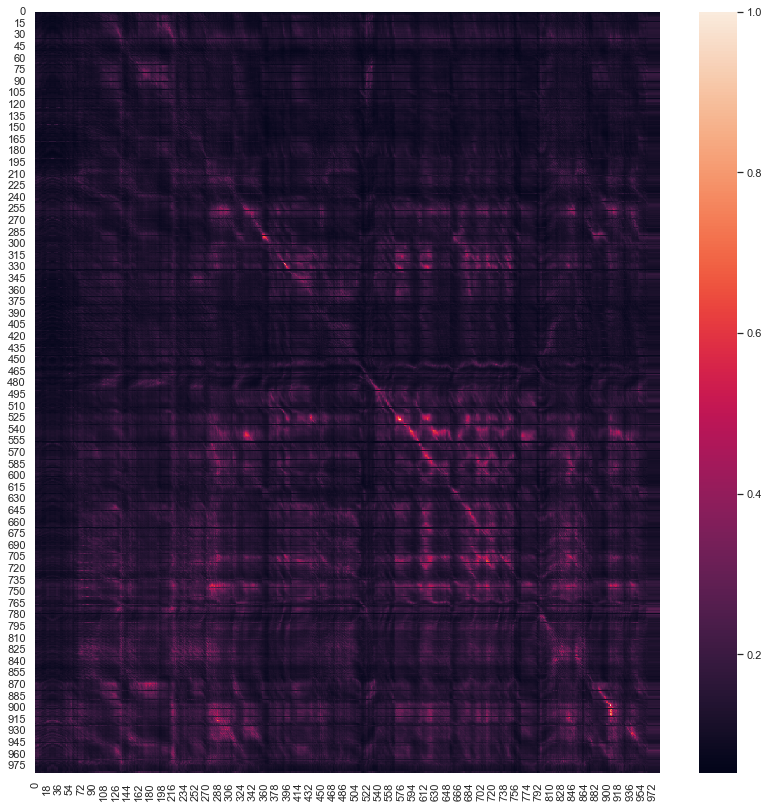

In [50]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

uniform_data = probability_matrix/np.max(probability_matrix)
# create figure and set size
np.save("Auto_encoder_morning_on_evening",uniform_data)
plt.figure(figsize=(14, 14))
ax = sns.heatmap(uniform_data) #cmap="YlGnBu" )

# plt.savefig('test50.png', dpi=600)
# # show the figure; this was slow
# plt.show()

In [ ]:
import pandas as pd
dataframe = pd.DataFrame(uniform_data)

In [ ]:
import pandas as pd
dataframe = pd.DataFrame(distance_table)

In [ ]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(30)  
# data = np.random.random(( 12 , 12 ))
plt.imshow( distance_table , cmap = 'autumn' , interpolation = 'nearest' )
  
plt.title( "Distance Heat Map", fontsize = 30 )
plt.xlabel("Evening Images", fontsize = 20)
plt.ylabel("Morning Images", fontsize = 20)
plt.tick_params(labelsize=15, pad = 6)
plt.show()

# Normalized Heat Map

In [ ]:
distance_table_norm = (distance_table/distance_table.max())*100
print(distance_table_norm)

In [ ]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(30)  
# data = np.random.random(( 12 , 12 ))
plt.imshow( distance_table_norm , cmap = 'summer' , interpolation = 'nearest' )
  
plt.title( "Distance Heat Map", fontsize = 30 )
plt.xlabel("Evening Images", fontsize = 20)
plt.ylabel("Morning Images", fontsize = 20)
plt.tick_params(labelsize=15, pad = 6)
plt.show()

In [ ]:
accuracy_list = []
count = 0
threshold_1 = 20
for i in distance_table:
    temp_min_1 = min(i)
    for j in range(threshold_1+1): 
        try: 
            if i[count+j] == temp_min_1:
                boolean = 1
                break
            else: 
                boolean = 0
        except: 
            print("Entered 1st exception for the ", count)
            continue
        if boolean == 0:
            for k in range(1,threshold_1 +1): 
                try: 
                    if int(i[count-k]) == temp_min_1:
                        boolean = 1
                        break
                    else: 
                        boolean = 0
                except: 
                    print("Entered 2nd exception for the ", count)
                    continue
            
            
    accuracy_list.append(boolean)  
    count+=1

In [ ]:
accuracy_list.count(1)

In [ ]:
dataframe.to_csv("./distance_matrix_deep_conv_auto_encoder_train_Morning_on_evening.csv")